# Tuto: convolve template to spike

author: steeve.laquitaine@epfl.ch

## Setup

Virtual env is `env_kilosort_silico`

You should have extracted the templates from a KS3 run by running `python3.9 -m src.pipes.postpro.univ_temp` in the terminal before. See usage in `univ_temp` module.

The dot product `W^T.D` provides the scaling amplitude of the best fitted template.

In [6]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.signal import correlate
from scipy.signal import correlation_lags

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.truth.silico import ground_truth
from src.pipes.postpro import univ_temp

# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/spiketrains.pkl'
RAW_LFP_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/traces.pkl'
CELL_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/cells/cell_3754013_trace.pkl'


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study'
EXAMPLE_CELL_ID = 4209594
EXAMPLE_CHANNEL_ID = 20
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms
CELL_TYPE = "PYR"
LOAD_WAVEFORM_EXTRACTOR = False
LOAD_GROUND_TRUTH = True
LOAD_PREP_TRACE = True


# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["sorting"]["deepnet"]["input"]["nearest_channel"]

# SET PLOT PARAMETERS
cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0,1,24))[:,:3]

# set colors for detected 
detected_colors = colors[:12,]
missed_colors = colors[12:,]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-05-05 14:45:43,362 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-05 14:45:43,400 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-05-05 14:45:43,402 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-05 14:45:43,438 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Fit (align and scale) templates

Plan: 
1. align all spikes to template 1.
2. crop spike and template boundaries to all have a common period. 

Cons:
- padding spikes and templates with zeros during alignment does not change the alignment but will change the best fit (projection) of the templates onto the spikes. 
Pachitariu 2023 do not pad with zeros nor modify the spikes or templates. They convolve the templates onto the entire recording to find the best fit.
- If we cut to have a common time window, one of the spike was shifted at + 20 timepoint, thus we would do the left cut at + 20 where we would lose most of the template and other spike shapes (as shown below). This does not work.

We could solve this by extracting spike waveforms over longer periods (- and + 6 ms instead of 3 ms), aligning (without padding) then cropping at - and + 3ms from the negative peak.

For now we solve it by fixing a universal template, and aligning and scaling all spikes to best fit that template (i.e., all spikes are normalized to that template). The more distant cell dots to that template dot in the reduced space have the most shapes and we predict that they should be the ones missed.

We will assume for now that spike and template dimensions are aligned by the ground truth timestamps for each spike provided by NEURON and the template timestamps produced by Kilosort3.


In [3]:
# custom functions
def align_with_crosscorr(template, spike):

    # calculate lag
    corr = correlate(spike, template, mode="full")
    lags = correlation_lags(spike.size, template.size, mode="full")
    lag = lags[np.argmax(corr)]        
    
    # shift spike indices by lag
    spike.index = spike.index - lag
    return spike

def plot_aligned_spike_and_template(template, spike, figsize:tuple):
    plt.subplots(figsize=figsize)
    spike.plot(label="spike");
    template.plot(label="template", color="r", linestyle="--");
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False);

In [4]:
# load spike data
all_instances = pd.read_pickle(INSTANCE_FILE_PATH)
channel_ids = pd.read_pickle(CHANNEL_IDS_FILE_PATH)
cells = pd.read_pickle(CELL_LABELS_FILE_PATH)
spike_status = pd.read_pickle(SPIKE_STATUS_FILE_PATH)
nearest_channel = pd.read_pickle(NEAREST_CHANNEL_FILE_PATH)

spike count: 66
2023-05-05 14:45:45,862 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-05 14:45:45,872 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0
spike count: 5
2023-05-05 14:45:45,937 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-05 14:45:45,946 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


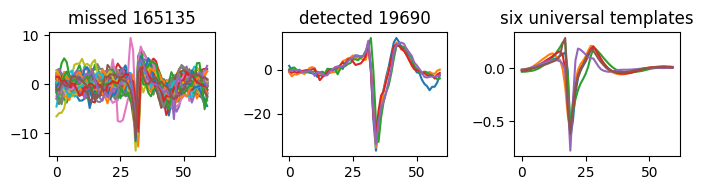

In [7]:
# plot a missed sparse cell
NEAREST_CHANNEL = 30
MISSED_CELL = 165135
DETECTED_CELL = 19690

# setup plots
fig, axes = plt.subplots(1,3, figsize=(7,2))

# plot a missed sparse cell
missed_cell_instances = all_instances.iloc[np.where((cells.values==MISSED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[0].plot(missed_cell_instances.T);
axes[0].set_title(f"missed {MISSED_CELL}");
print("spike count:", missed_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[MISSED_CELL] == missed_cell_instances.shape[0], "spike count does not make sense"

# plot a detected sparse cell
detected_cell_instances = all_instances.iloc[np.where((cells.values==DETECTED_CELL) & (channel_ids.values==NEAREST_CHANNEL) & (spike_status.values==True))[0].tolist()]
axes[1].plot(detected_cell_instances.T);
axes[1].set_title(f"detected {DETECTED_CELL}");

print("spike count:", detected_cell_instances.shape[0])
Truth = ground_truth.load(data_conf)
assert Truth.get_total_num_spikes()[DETECTED_CELL] == detected_cell_instances.shape[0], "spike count does not make sense"

# plot Kilosort3's six universal templates
univ_templates = univ_temp.load(data_conf)
univ_templates = univ_templates.T[:,:-1]
univ_templates = univ_templates
axes[2].plot(univ_templates.T);
axes[2].set_title("six universal templates");

plt.tight_layout()

/tmp/ipykernel_54129/1561247717.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(figsize=figsize)


<Figure size 100x100 with 0 Axes>

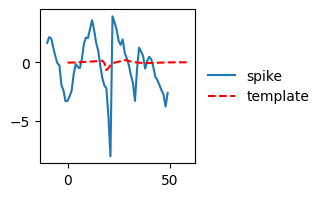

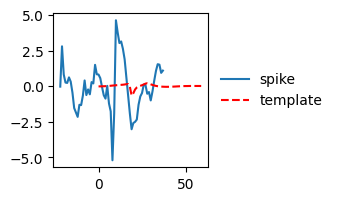

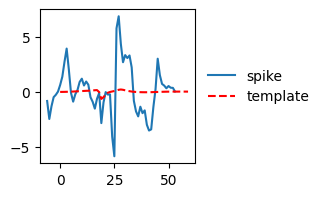

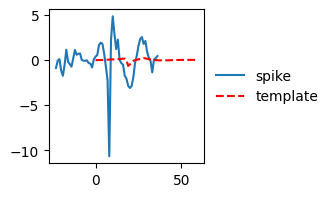

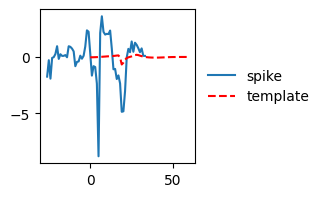

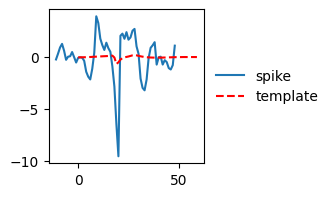

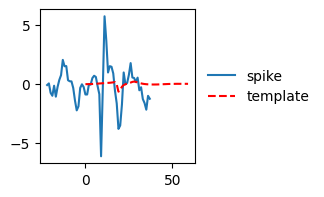

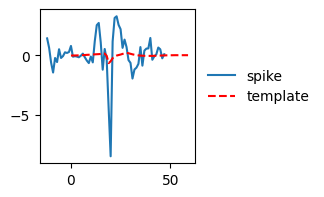

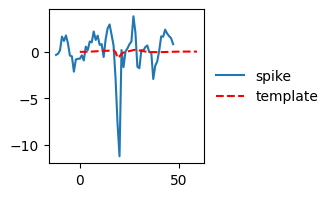

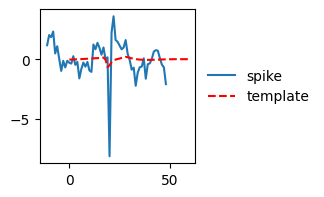

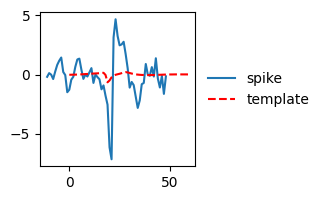

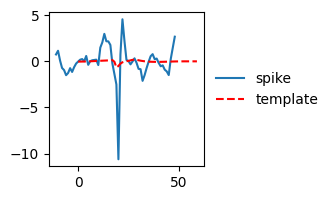

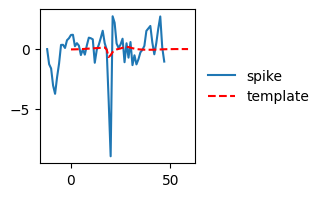

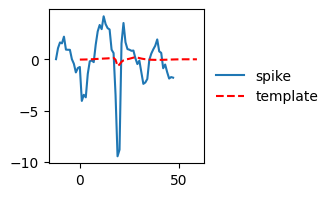

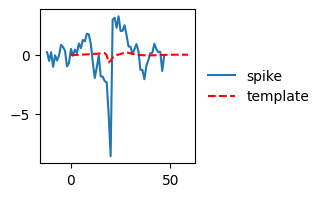

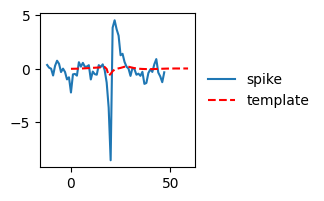

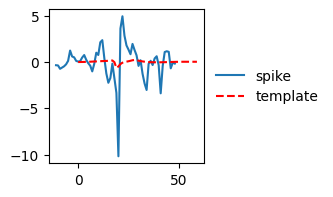

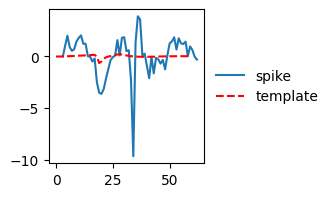

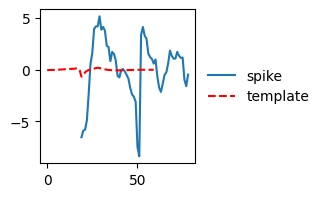

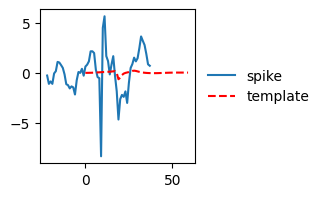

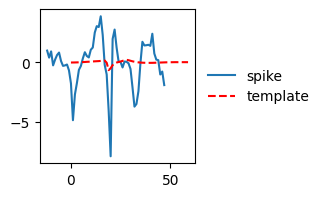

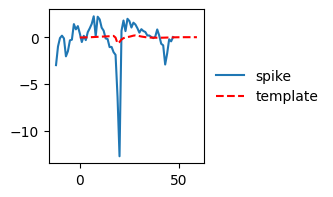

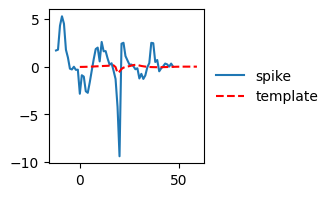

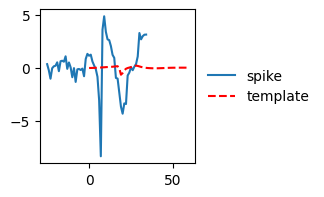

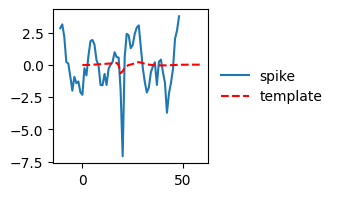

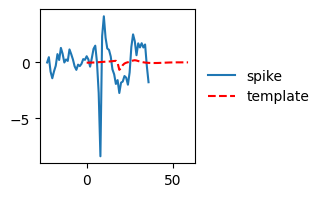

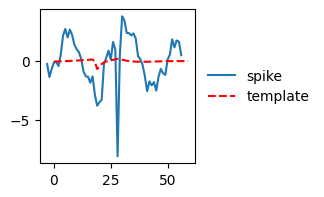

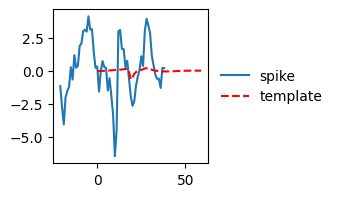

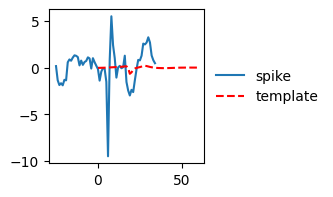

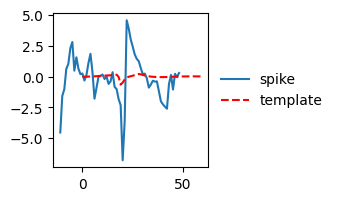

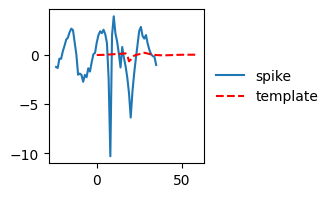

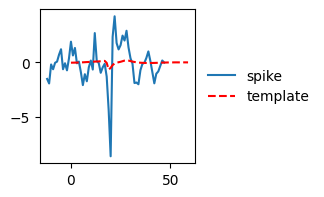

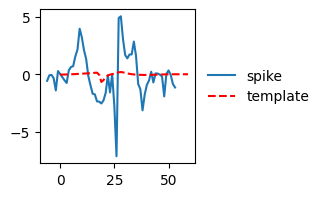

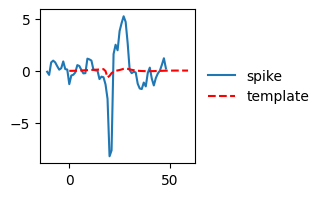

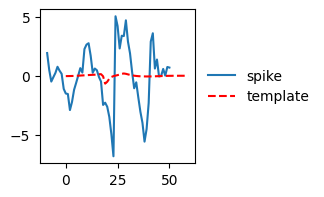

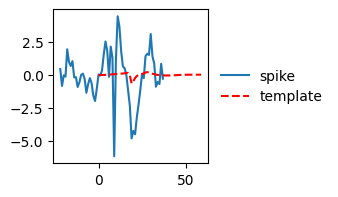

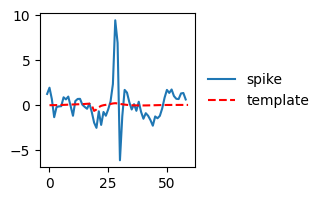

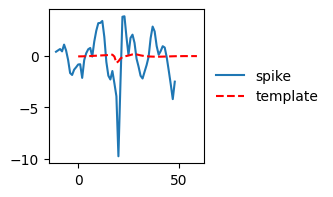

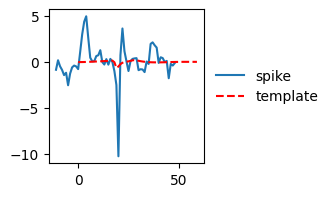

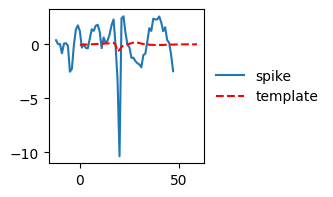

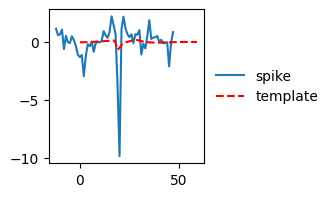

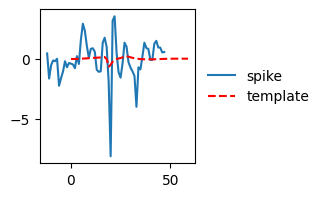

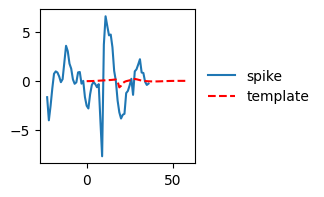

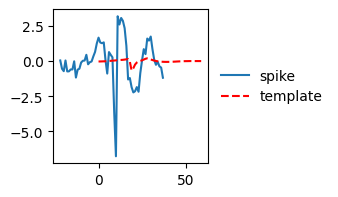

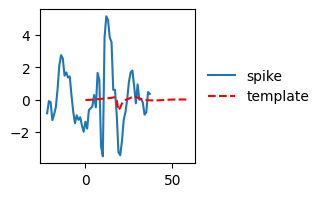

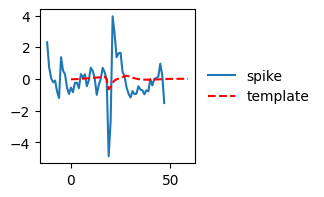

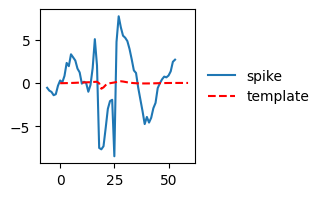

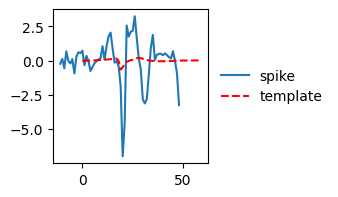

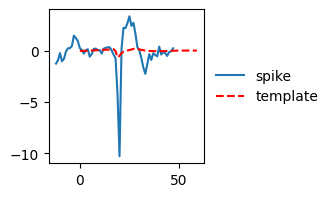

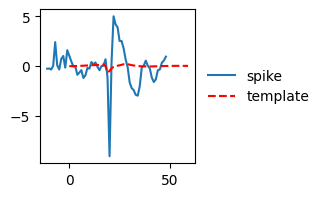

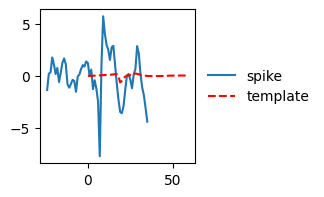

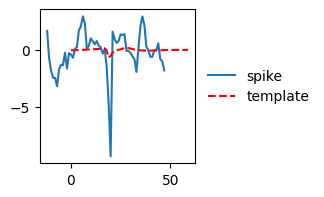

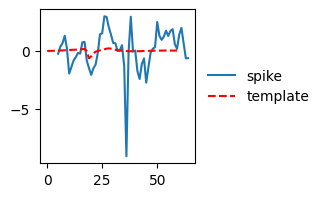

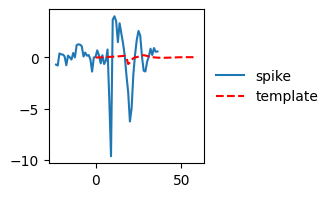

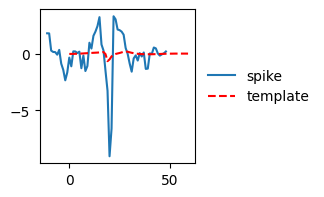

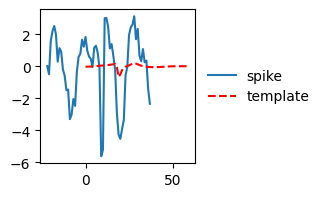

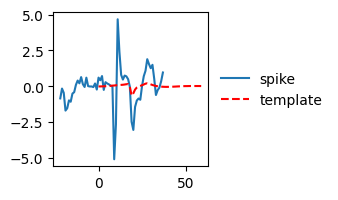

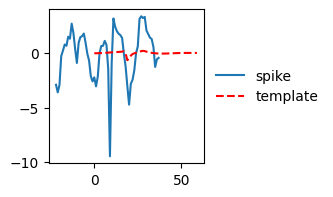

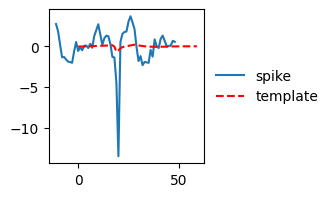

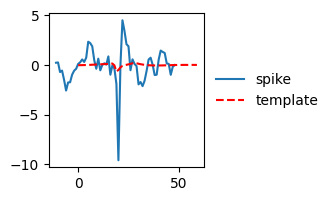

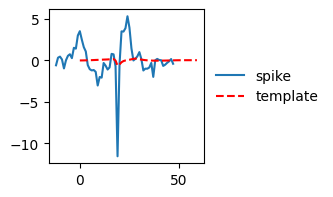

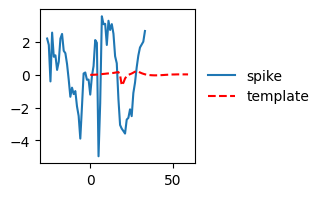

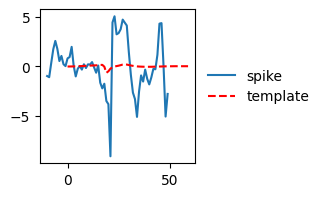

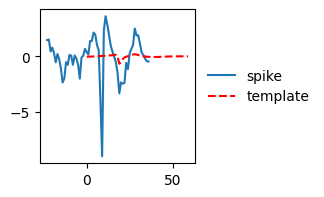

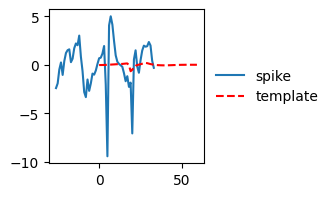

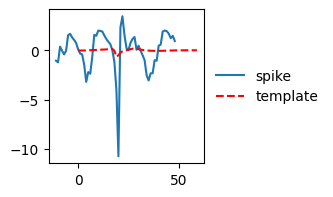

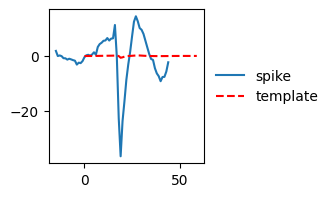

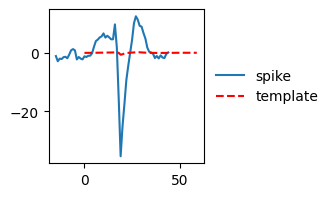

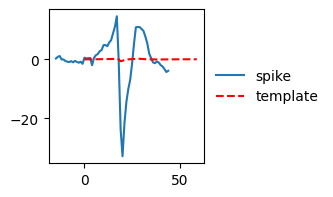

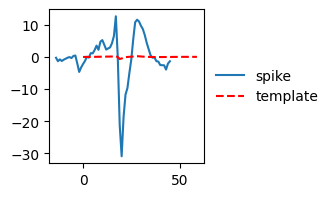

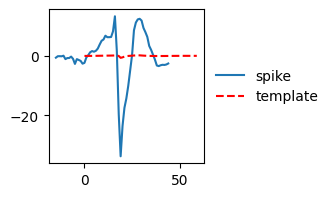

In [8]:
# fix a template
plt.figure(figsize=(1,1))
template = pd.Series(univ_templates[0,:])

# get spikes
instances_all = pd.DataFrame(np.vstack([missed_cell_instances, detected_cell_instances]))

# align all spikes
aligned_spikes = []
for ix in range(instances_all.shape[0]): 

    # get spike
    spike = instances_all.iloc[ix]

    # align with template
    aligned_spike = align_with_crosscorr(template, spike)

    # record
    aligned_spikes.append(aligned_spike)
    plot_aligned_spike_and_template(template, spike, figsize=(2,2))